In [3]:
import re
import pandas as pd # to dataframes
import numpy as np #to math
import matplotlib.pyplot as plt
import gensim
import spacy
import pyLDAvis

from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models.word2vec import Word2Vec
import pyLDAvis.gensim 

from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.model_selection import GridSearchCV

In [4]:
df_combined_text = pd.read_csv('/Users/issy/Desktop/Capstone project /capstone-project/clean combined  text')
df_combined_text = df_combined_text.iloc[:,1]
df_combined_text.head()

0    s g e sativa afghani equilibrium marijuana ene...
1    cannatonic marijuana calming happy mellow rela...
2    blue dream marijuana creative energizing eupho...
3    goji og marijuana creative energizing euphoria...
4    green love potion marijuana aroused happy rela...
Name: combined_text, dtype: object

In [5]:
#Convert to list 
data = df_combined_text.tolist()


def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc= True))

data_words = list(sent_to_words(data))
print(data_words[:1])

[['sativa', 'afghani', 'equilibrium', 'marijuana', 'energizing', 'euphoria', 'happy', 'relaxing', 'sage', 'spicy', 'add', 'adhd', 'anxiety', 'chronic', 'pain', 'depression', 'hyperactivity', 'insomnia', 'migraine', 'mood', 'swing', 'nausea', 'stress', 'earthy', 'herbal', 'sage', 'spicy', 'woody', 'popular', 'marijuana', 'won', 'second', 'position', 'cannabis', 'cup', 'strong', 'indica', 'thc', 'level', 'percent', 'hybrid', 'produced', 'mating', 'afghani', 'indica', 'big', 'sur', 'holy', 'flowering', 'period', 'around', 'day', 'vigorous', 'growth', 'result', 'beautiful', 'fresh', 'green', 'coloured', 'leaf', 'straight', 'growth', 'though', 'indica', 'produce', 'strong', 'sativa', 'high', 'last', 'system', 'quite', 'long', 'nice', 'uplifting', 'aroma', 'earthy', 'pine', 'flavoured', 'undertone', 'well', 'taste', 'quite', 'pleasant', 'well', 'blend', 'sage', 'pine', 'earthy', 'spicy', 'flavour', 'hint', 'sandalwood', 'instantly', 'begin', 'feeling', 'euphoric', 'happy', 'smoking', 'high',

In [16]:
import en_core_web_sm

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append(" ".join([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags]))
    return texts_out

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# Run in terminal: python3 -m spacy download en
nlp = en_core_web_sm.load()

# Do lemmatization keeping only Noun, Adj, Verb, Adverb
data_lemmatized = lemmatization(data_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:2])

['energize euphoria happy relax sage spicy add adhd anxiety chronic pain depression hyperactivity mood swing nausea stress earthy herbal sage spicy woody popular win second position cup strong level percent hybrid produce mate period day vigorous growth result beautiful fresh green coloured leaf straight growth indica produce strong high last system quite long nice uplift aroma earthy pine flavour undertone well taste quite pleasant blend sage pine earthy spicy flavour hint sandalwood instantly begin feel euphoric happy smoking high term creative energetic smoke mood work creative project well treat stress anxiety relax energize slowly vanish depression use get relief different kind mild pain loss appetite', 'cannatonic marijuana calm happy mellow relax uplift citrus herbal sour spicy sweet woody anxiety chronic pain spasm stress citrus earthy herbal sour spicy sweet cannatonic evenly balanced indica create cross powerful ultra haze strain perfect high powered medicinal help really kic

In [17]:
vectorizer = CountVectorizer(analyzer='word',
                             min_df = 5, 
                             stop_words='english',
                             lowercase= True,
                             token_pattern='[a-zA-Z0-9]{3,}')

data_vector = vectorizer.fit_transform(data_lemmatized)

In [18]:
#Materialize the sparse data

data_dense = data_vector.todense()

#Compute Sparsicity = % of non-zero cells 
print("Sparcity: ", ((data_dense>0).sum()/data_dense.size)*100, "%")

Sparcity:  2.8352304001798756 %


In [19]:
#Build LDA Model 

lda = LatentDirichletAllocation(n_components= 15,
                                max_iter= 50,
                                learning_method= 'online',
                                random_state= 100,
                                batch_size= 128,
                                evaluate_every= -1,
                                n_jobs= -1)
lda_output = lda.fit_transform(data_vector)
print(lda)

LatentDirichletAllocation(learning_method='online', max_iter=50,
                          n_components=15, n_jobs=-1, random_state=100)


In [24]:
import pprint

# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda.score(data_vector))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda.perplexity(data_vector))

# See model parameters
print(lda.get_params)

Log Likelihood:  -6149730.605493214
Perplexity:  419.4905599646923
<bound method BaseEstimator.get_params of LatentDirichletAllocation(learning_method='online', max_iter=50,
                          n_components=15, n_jobs=-1, random_state=100)>


In [25]:
#Define search params 
search_params = {'n_components':[3,5,10,15,20,25,30], 'learning_decay': [0.5,0.7,0.9]}

#initialize the model
lda_model= LatentDirichletAllocation()
model = GridSearchCV(lda_model, param_grid=search_params, cv = 3)
model.fit(data_vector)


GridSearchCV(cv=3, estimator=LatentDirichletAllocation(),
             param_grid={'learning_decay': [0.5, 0.7, 0.9],
                         'n_components': [3, 5, 10, 15, 20, 25, 30]})

In [27]:
#Best Model 

best_lda_model = model.best_estimator_
print("Best Model's Parameters:  ", model.best_params_)
print('Best Log  Likelihood Score: ', model.best_score_)
print("Model Perplexity: ", best_lda_model.perplexity(data_vector))

Best Model's Parameters:   {'learning_decay': 0.9, 'n_components': 3}
Best Log  Likelihood Score:  -2092853.363149658
Model Perplexity:  430.7257442884276


In [28]:
#Create DTM 
lda_output = best_lda_model.transform(data_vector)

#column names 
topicnames = ["Topic" + str(i) for i in range(best_lda_model.n_components)]

#index names 
docnames = ["Doc" + str(i) for i in range(len(data))]

#pandas df 
df_dtm = pd.DataFrame(np.round(lda_output,2), columns= topicnames, index = docnames)

#identifying dominant topic 
dom_topic = np.argmax(df_dtm.values, axis = 1)
df_dtm['dom_topic'] = dom_topic

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_dtm.head(15).style.applymap(color_green).applymap(make_bold)
df_document_topics



,Topic0,Topic1,Topic2,dom_topic
Doc0,0.020000,0.000000,0.980000,2
Doc1,0.420000,0.580000,0.000000,1
Doc2,0.000000,0.000000,0.990000,2
Doc3,0.310000,0.000000,0.690000,2
Doc4,0.000000,0.050000,0.950000,2
Doc5,0.130000,0.230000,0.630000,2
Doc6,0.000000,0.000000,0.990000,2
Doc7,0.120000,0.000000,0.880000,2
Doc8,0.000000,0.000000,0.990000,2
Doc9,0.000000,0.000000,0.990000,2


In [31]:
topic_dist = df_dtm['dom_topic'].value_counts().reset_index(name = 'Num Documents')
topic_dist.columns = ['Topic_Num','Num_Documents']
topic_dist

,Topic_Num,Num_Documents
0,1,3648
1,0,3253
2,2,2023


In [34]:
import pyLDAvis.sklearn 

pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(best_lda_model, data_vector, vectorizer, mds='tsne')
panel

/Users/issy/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/Users/issy/opt/anaconda3/lib/python3.9/site-packages/pyLDAvis/_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(
/Users/issy/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/Users/issy/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
1      209.914825 -565.721802       1        1  40.745323
0      358.201050 -296.957886       2        1  37.986665
2       50.437405 -303.004364       3        1  21.268012, topic_info=        Term          Freq         Total Category  logprob  loglift
2507    sour  12268.000000  12268.000000  Default  30.0000  30.0000
2680   sweet  19721.000000  19721.000000  Default  29.0000  29.0000
2911    user   1496.000000   1496.000000  Default  28.0000  28.0000
429   cherry   2240.000000   2240.000000  Default  27.0000  27.0000
2714   taste   2573.000000   2573.000000  Default  26.0000  26.0000
...      ...           ...           ...      ...      ...      ...
1206   happy   1462.705696   6901.206716   Topic3  -4.9977  -0.0034
2210   relax   1454.076069   9765.875739   Topic3  -5.0036  -0.3566
133    aroma   1299.139879   7587.449590   Topic3  -5.1162  -0.2168
972     feel   1297.607972   7931.211039   Topic3  -5.1174  -0.2623
1063  fruity   1203.946702   9874.845308   Topic3  -5.1923  -0.5564

[293 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
8         1  0.346128      accent
8         2  0.652083      accent
8         3  0.001928      accent
27        1  0.003137    activate
27        2  0.997705    activate
...     ...       ...         ...
2976      3  0.017257  watermelon
2986      2  0.996124     wedding
3011      3  0.992923      widely
3033      1  0.961629      wizard
3042      1  0.983766      wookie

[509 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 3])

In [35]:
#Topic keyword Matrix

df_topic_keywords = pd.DataFrame(best_lda_model.components_)
df_topic_keywords.columns = vectorizer.get_feature_names_out()
df_topic_keywords.index = topicnames
df_topic_keywords.head()

,abduction,ability,able,absolute,absolutely,abundant,abusive,acapulco,accent,accented,...,yeti,yield,yoga,zap,zen,zest,zesty,zkittlez,zombie,zone
Topic0,0.335410,16.678008,95.454337,1.576262,26.766556,0.356444,0.336737,0.435185,2030.278513,473.691780,...,0.372061,0.759203,0.370018,4.668417,5.560209,24.534109,19.355242,65.480879,0.341008,4.369786
Topic1,6.301098,22.972666,40.087334,4.471458,77.498895,0.336616,9.509392,5.876929,1080.817898,182.734295,...,11.283114,37.896688,6.488724,5.444484,4.941797,3.033303,1.640391,3.170363,14.972831,8.117412
Topic2,0.363493,49.349326,93.458330,7.952279,47.734549,15.306941,9.153871,10.687886,5.903589,9.573925,...,1.344825,89.344109,6.141258,3.887099,15.497994,0.432588,36.004367,0.348758,3.686160,7.512801


In [37]:
#show top keywords for each topic

def show_topics(vectorizer = vectorizer, lda_model = lda_model, n_words = 20):
    keywords = np.array(vectorizer.get_feature_names_out())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keys = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keys))
    return topic_keywords

topic_keywords = show_topics(vectorizer= vectorizer, lda_model= best_lda_model, n_words = 15)

df_topics = pd.DataFrame(topic_keywords)
df_topics.columns = ['Word '+str(i) for i in range(df_topics.shape[1])]
df_topics.index = ['Topic '+str(i) for i in range(df_topics.shape[0])]
df_topics


,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,high,sour,sweet,chronic,fruity,depression,stress,citrus,spicy,level,feel,fatigue,happy,average,mood
Topic 1,high,chronic,pain,sweet,spicy,body,relax,earthy,level,depression,bud,stress,mind,thc,herbal
Topic 2,sweet,high,pain,chronic,depression,level,stress,anxiety,thc,earthy,body,bud,treat,taste,happy


In [39]:
# Define function to predict topic for a given text document.
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

def predict_topic(text, nlp=nlp):
    global sent_to_words
    global lemmatization

    # Step 1: Clean with simple_preprocess
    mytext_2 = list(sent_to_words(text))

    # Step 2: Lemmatize
    mytext_3 = lemmatization(mytext_2, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

    # Step 3: Vectorize transform
    mytext_4 = vectorizer.transform(mytext_3)

    # Step 4: LDA Transform
    topic_probability_scores = best_lda_model.transform(mytext_4)
    topic = df_topic_keywords.iloc[np.argmax(topic_probability_scores), :].values.tolist()
    return topic, topic_probability_scores

# Predict the topic
mytext = ["Some text about christianity and bible"]
topic= predict_topic(text = mytext)
print(topic)

([0.3354095892054437, 16.678008407205866, 95.4543366162822, 1.5762621042281704, 26.76655628333544, 0.3564437092976432, 0.33673693212707156, 0.4351847710257972, 2030.2785129777906, 473.6917802033705, 0.3482838379151627, 0.33452129862843166, 452.6025006884851, 14.670341738117484, 751.7389810696678, 16.316843364861345, 5.279967370189766, 0.339284684190816, 0.33415501495941985, 13.432408859188326, 5.962631515362645, 90.96677352212501, 0.3659197840633021, 0.3796553970552521, 19.060149288410216, 1.7595236474453353, 14.071963781366911, 318.13452672511977, 6.36937476340685, 30.84477932858081, 18.519609203542313, 4.693843907569801, 19.343622409444382, 1297.8143360363601, 0.3634846038363124, 3.0563080858829372, 8.876220794830175, 0.34702193420613126, 0.43925044961057447, 0.3344603979866543, 1204.9364038900603, 1.6832326597745697, 5.7454185923904655, 7.269936162942931, 0.38580521572180504, 10.564531298781098, 0.3341239698318095, 0.33366933844598556, 141.67494173214712, 0.37731433117461866, 4.8289

In [40]:
#construct kmeans clusters 

from sklearn.cluster import KMeans

clusters = KMeans(n_clusters= 15, random_state= 100).fit_predict(lda_output)

#Build SVD 
svd_model = TruncatedSVD(n_components= 2)
lda_output_svd = svd_model.fit_transform(lda_output)

# X and Y axes of the plot using SVD decomposition
x = lda_output_svd[:, 0]
y = lda_output_svd[:, 1]

# Weights for the 15 columns of lda_output, for each component
print("Component's weights: \n", np.round(svd_model.components_, 2))

# Percentage of total information in 'lda_output' explained by the two components
print("Perc of Variance Explained: \n", np.round(svd_model.explained_variance_ratio_, 2))

Component's weights: 
 [[ 0.64  0.73  0.23]
 [ 0.74 -0.5  -0.46]]
Perc of Variance Explained: 
 [0.07 0.51]


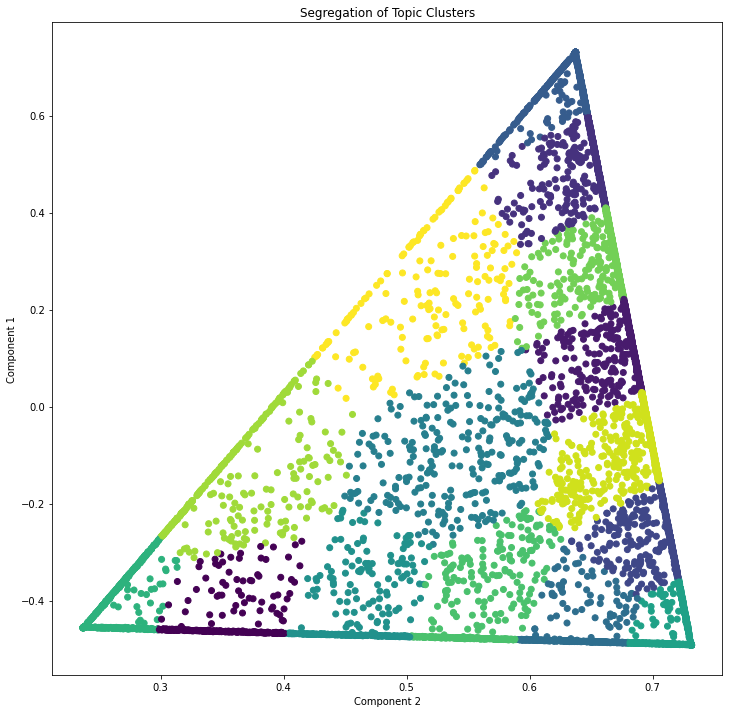

In [42]:
#Plot
plt.figure(figsize=(12,12))
plt.scatter(x,y, c = clusters)
plt.xlabel('Component 2')
plt.ylabel('Component 1')
plt.title('Segregation of Topic Clusters')
plt.show()

In [6]:
from sklearn.metrics.pairwise import euclidean_distances
import spacy 
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

def similar_documents(text, doc_topic_probs, documents = data, nlp=nlp, top_n=5, verbose=False):
    topic, x  = predict_topic(text)
    dists = euclidean_distances(x.reshape(1, -1), doc_topic_probs)[0]
    doc_ids = np.argsort(dists)[:top_n]
    if verbose:        
        print("Topic KeyWords: ", topic)
        print("Topic Prob Scores of text: ", np.round(x, 1))
        print("Most Similar Doc's Probs:  ", np.round(doc_topic_probs[doc_ids], 1))
    return doc_ids, np.take(documents, doc_ids)

In [7]:
mytext = ["Blue Dream, a sativa-dominant hybrid originating in California, has achieved legendary status among West Coast strains. Crossing a Blueberry indica with the sativa Haze, Blue Dream balances full-body relaxation with gentle cerebral invigoration. Novice and veteran consumers alike enjoy the level effects of Blue Dream, which ease you gently into a calm euphoria. Some Blue Dream phenotypes express a more indica-like look and feel, but the sativa-leaning variety remains most prevalent."]
doc_ids, docs = similar_documents(text=mytext, doc_topic_probs=lda_output, documents = data, top_n=1, verbose=True)
print('\n', docs[0][:500])

NameError: name 'lda_output' is not defined